In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torchinfo
import torchtext.transforms as T
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from torchlake.common.controller.evaluator import ClassificationEvaluator
from torchlake.common.controller.trainer import ClassificationTrainer
from torchlake.common.schemas import NlpContext
from torchlake.common.utils.platform import get_file_size
from torchlake.text_classification.models import TextCnn
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

# setting


In [2]:
data_path = Path("../../data/childrenBooksAndStories")
artifacts_path = Path("../../artifacts/textcnn")

In [3]:
batch_size = 32
context = NlpContext()

In [4]:
tokenizer = get_tokenizer("basic_english")

# data

In [5]:
data = pd.read_csv(
    data_path.joinpath("children_stories.csv").as_posix(),
    encoding="latin-1",
    usecols=["cats", "desc"],
)

In [6]:
# 移除空標籤
data = data.query('cats != "Age "')

In [7]:
def convert_label(label: str) -> int:
    """convert age label to label

    Args:
        label (str): age label, in format like 'x-y', 'x+'

    Returns:
        int: 0 -> before kindergarten, 1 -> kindergarten, 2 -> elementary school
    """

    label = label.replace("6months", "0.5")

    if "-" in label:
        [lower, upper] = label.split("-")
        lower, upper = float(lower), float(upper)
    else:
        lower = float(label.replace("+", ""))
        upper = np.Inf

    if 3 >= lower:
        return 1
    elif 8 >= lower:
        return 2
    else:
        return 0

In [8]:
data["cats"] = data.cats.str.replace("Age\s", "", regex=True)

In [9]:
data["cats"] = data.cats.apply(convert_label)

In [10]:
data.cats.value_counts()

cats
1    179
2    146
0    103
Name: count, dtype: int64

In [11]:
train_data, test_data = train_test_split(data, test_size=1 / 5)

In [12]:
vocab = build_vocab_from_iterator(
    train_data["desc"].str.split(),
    specials=context.special_tokens,
    min_freq=context.min_frequency,
)

vocab.set_default_index(context.unk_idx)

In [13]:
text_transform = T.Sequential(
    T.VocabTransform(vocab),
    T.Truncate(context.max_seq_len - 2),
    T.AddToken(token=context.bos_idx, begin=True),
    T.AddToken(token=context.eos_idx, begin=False),
    T.ToTensor(),
    T.PadTransform(context.max_seq_len, context.padding_idx),
)

In [14]:
def collate_fn(batch: np.ndarray):
    text_placeholder, label_placeholder = [], []

    for label, text in batch:
        text = tokenizer(text)
        text = text_transform(text)
        text_placeholder.append(text)
        label_placeholder.append(label)

    return torch.stack(text_placeholder), torch.Tensor(label_placeholder)

In [15]:
train_iter = DataLoader(
    train_data.to_numpy(),
    batch_size=batch_size,
    collate_fn=collate_fn,
    shuffle=True,
    drop_last=True,
)

test_iter = DataLoader(
    test_data.to_numpy(),
    batch_size=batch_size,
    collate_fn=collate_fn,
)

In [16]:
for text, label in train_iter:
    print(text.shape, label.shape)
    break

torch.Size([32, 256]) torch.Size([32])


# model


In [17]:
VOCAB_SIZE = len(vocab)
LABEL_SIZE = data.cats.nunique()

In [18]:
DEVICE = torch.device(context.device)

In [19]:
EMBED_DIM = 32

In [20]:
model = TextCnn(VOCAB_SIZE, EMBED_DIM, output_size=LABEL_SIZE, padding_idx=context.padding_idx).to(DEVICE)

In [21]:
torchinfo.summary(model)

Layer (type:depth-idx)                        Param #
TextCnn                                       --
├─Embedding: 1-1                              29,312
├─MultiKernelConvModule: 1-2                  --
│    └─FlattenFeature: 2-1                    --
│    │    └─Sequential: 3-1                   --
│    └─ModuleList: 2-2                        --
│    │    └─ConvBnRelu: 3-2                   2,080
│    │    └─ConvBnRelu: 3-3                   3,104
│    │    └─ConvBnRelu: 3-4                   4,128
├─Linear: 1-3                                 291
Total params: 38,915
Trainable params: 38,915
Non-trainable params: 0

# train


In [22]:
EPOCHES = 20

In [23]:
trainer = ClassificationTrainer(EPOCHES, DEVICE)

In [24]:
criterion = trainer.get_criterion(LABEL_SIZE)
optimizer = torch.optim.Adam(model.parameters())

In [25]:
training_loss = trainer.run(train_iter, model, optimizer, criterion)

100%|██████████| 10/10 [00:00<00:00, 16.34it/s]


epoch 1 : 0.5462189435958862


100%|██████████| 10/10 [00:00<00:00, 81.63it/s]


epoch 2 : 0.5009996086359024


100%|██████████| 10/10 [00:00<00:00, 63.75it/s]


epoch 3 : 0.47654440104961393


100%|██████████| 10/10 [00:00<00:00, 79.75it/s]


epoch 4 : 0.446287202835083


100%|██████████| 10/10 [00:00<00:00, 64.24it/s]


epoch 5 : 0.4312040716409683


100%|██████████| 10/10 [00:00<00:00, 103.31it/s]


epoch 6 : 0.4072060763835907


100%|██████████| 10/10 [00:00<00:00, 73.00it/s]


epoch 7 : 0.3837520986795425


100%|██████████| 10/10 [00:00<00:00, 94.98it/s]


epoch 8 : 0.36050117015838623


100%|██████████| 10/10 [00:00<00:00, 80.22it/s]


epoch 9 : 0.34032437205314636


100%|██████████| 10/10 [00:00<00:00, 103.65it/s]


epoch 10 : 0.31682728230953217


100%|██████████| 10/10 [00:00<00:00, 65.70it/s]


epoch 11 : 0.29404512941837313


100%|██████████| 10/10 [00:00<00:00, 84.95it/s]


epoch 12 : 0.27723858058452605


100%|██████████| 10/10 [00:00<00:00, 67.39it/s]


epoch 13 : 0.25513252019882204


100%|██████████| 10/10 [00:00<00:00, 60.03it/s]


epoch 14 : 0.2363515868782997


100%|██████████| 10/10 [00:00<00:00, 66.44it/s]


epoch 15 : 0.21665813028812408


100%|██████████| 10/10 [00:00<00:00, 86.35it/s]


epoch 16 : 0.1989798814058304


100%|██████████| 10/10 [00:00<00:00, 85.46it/s]


epoch 17 : 0.18470836728811263


100%|██████████| 10/10 [00:00<00:00, 86.19it/s]


epoch 18 : 0.16738602966070176


100%|██████████| 10/10 [00:00<00:00, 74.09it/s]


epoch 19 : 0.15462585762143136


100%|██████████| 10/10 [00:00<00:00, 104.00it/s]

epoch 20 : 0.14073565900325774


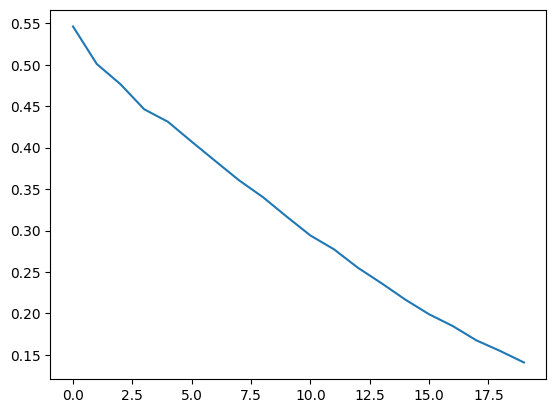

In [26]:
plt.plot(training_loss)

# inference


In [27]:
evaluator = ClassificationEvaluator(LABEL_SIZE, DEVICE)

In [28]:
confusion_matrix = evaluator.run(test_iter, model)

100%|██████████| 3/3 [00:00<00:00, 52.50it/s]

[[ 5  5 13]
 [ 0 20  3]
 [ 3 15 22]]


In [35]:
per_class_accuracy = evaluator.get_per_class_accuracy(confusion_matrix)

In [37]:
evaluator.show_per_class_accuracy(data.cats.unique(), per_class_accuracy)

1         : 0.21739130434782608
2         : 0.8695652173913043
0         : 0.55


In [44]:
evaluator.get_total_accuracy(confusion_matrix)

array(0.54651163)

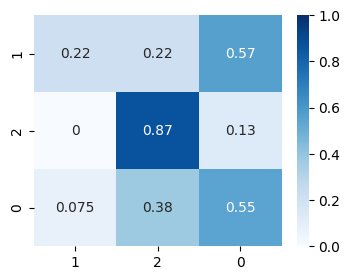

In [40]:
evaluator.plot_confusion_matrix(confusion_matrix, data.cats.unique(), cmap="Blues")

# File

In [29]:
model_path = artifacts_path.joinpath("textcnn.pth")

In [30]:
torch.save(model.state_dict(), model_path)

In [33]:
get_file_size(model_path, unit="K")

'155.37KB'

In [32]:
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>